# Lucas-Kanade Object Tracker

This notebook implements a Lucas-Kanade tracker for object tracking in video sequences. The tracker uses affine transformation parameters to track objects across frames.

## Table of Contents
1. [Import Libraries](#imports)
2. [Lucas-Kanade Tracker Class](#tracker-class)
3. [Utility Functions](#utility-functions)
4. [Main Tracking Function](#main-tracking)
5. [Video Processing Functions](#video-processing)
6. [Run Tracking](#run-tracking)

## 1. Import Libraries 

Import all necessary libraries for computer vision, numerical computation, and visualization.

In [1]:
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from IPython.display import clear_output
from tqdm import tqdm
import time

## 2. Lucas-Kanade Tracker 

The main tracker class that implements the Lucas-Kanade algorithm with affine transformation.

In [2]:
class LucasKanadeTracker:
    def __init__(self, sobel_kernel_size=5, convergence_thresh=0.001, max_iters=200):
        """
        Initialize Lucas-Kanade tracker

        Args:
            sobel_kernel_size: Size of Sobel kernel for gradient computation
            threshold: Convergence threshold for parameter updates
            max_iterations: Maximum number of iterations per frame
        """
        self.convergence_thresh = convergence_thresh
        self.max_iters = max_iters
        self.sobel_kernel_size = sobel_kernel_size

### Gradient Computation

Compute image gradients using Sobel operators for the Lucas-Kanade algorithm.

In [3]:

def compute_image_gradients(self, image):
    """
    Compute image gradients using Sobel operators

    Args:
        image: Input grayscale image

    Returns:
        gx, gy: Horizontal and vertical gradients
    """
    gx = cv2.Sobel(image.astype(np.float32), cv2.CV_64F, 1, 0, ksize=self.sobel_kernel_size)
    gy = cv2.Sobel(image.astype(np.float32), cv2.CV_64F, 0, 1, ksize=self.sobel_kernel_size)
    return gx, gy

LucasKanadeTracker.compute_image_gradients = compute_image_gradients

### Affine Transformation

Create affine transformation matrix from 6 parameters.

In [4]:
def affine_warp_matrix(self, affine_params):
    """
    Create affine transformation matrix from parameters

    Args:
        p: 6-parameter vector [p1, p2, p3, p4, p5, p6]

    Returns:
        3x2 affine transformation matrix
    """
    return np.array([
            [1 + affine_params[0], affine_params[2], affine_params[4]],
            [affine_params[1], 1 + affine_params[3], affine_params[5]]
        ])

LucasKanadeTracker.affine_warp_matrix = affine_warp_matrix

### Rectangle Update and Image Cropping

Update bounding box coordinates and crop images based on transformation.

In [5]:
def get_updated_rectangle(self, transformation_matrix, input_rectangle, image_width, image_height, image):
    # Top-left corner in homogeneous coordinates
    top_left_homogeneous = np.array([[input_rectangle[0]], [input_rectangle[1]], [1]])

    # Transform top-left corner
    updated_top_left_homogeneous = transformation_matrix @ top_left_homogeneous

    # Extract coordinates ensuring they stay within image boundaries
    updated_top_left_x = max(0, updated_top_left_homogeneous[0, 0])
    updated_top_left_y = max(0, updated_top_left_homogeneous[1, 0])

    # Calculate bottom-right coordinates within image boundaries
    updated_bottom_right_x = min(image.shape[1], updated_top_left_x + image_width)
    updated_bottom_right_y = min(image.shape[0], updated_top_left_y + image_height)
    
    updated_rectangle = [
        int(updated_top_left_x),
        int(updated_top_left_y),
        int(updated_bottom_right_x),
        int(updated_bottom_right_y)
    ]

    return updated_rectangle

def crop_frame(self, image, box):
    """
    Crop image to specified box

    Args:
        image: Input image
        box: Bounding box [x, y, w, h]

    Returns:
        Cropped image
    """
    return image[box[1]:box[3], box[0]:box[2]]

def transform_bounding_box(self, affine_matrix, initial_box, box_width, box_height, frame):
        top_left = np.array([[initial_box[0]], [initial_box[1]], [1]])
        new_top_left = affine_matrix @ top_left

        x1 = max(0, new_top_left[0, 0])
        y1 = max(0, new_top_left[1, 0])
        x2 = min(frame.shape[1], x1 + box_width)
        y2 = min(frame.shape[0], y1 + box_height)

        return [int(x1), int(y1), int(x2), int(y2)]


LucasKanadeTracker.get_updated_rectangle = get_updated_rectangle
LucasKanadeTracker.crop_frame = crop_frame
LucasKanadeTracker.transform_bounding_box = transform_bounding_box


### Steepest Descent Computation

Compute steepest descent images for the Lucas-Kanade optimization.

In [6]:
def compute_steepest_descent_warped(self, gx, gy, rect):
    # rows/cols inside ROI
    gradient_descent_vectors = []

    for row in range(rect[1], rect[3]):
        for col in range(rect[0], rect[2]):
            gradient_vector = np.array([gx[row][col], gy[row][col]])
            jacobian_matrix = np.array([[col, 0, row, 0, 1, 0], [0, col, 0, row, 0, 1]])
            gradient_descent_matrix = np.matmul(gradient_vector, jacobian_matrix)
            gradient_descent_vectors.append(gradient_descent_matrix)

    return gradient_descent_vectors

    
def compute_steepest_descent(self, grad_x, grad_y, box):
        descent_vectors = []
        for y in range(box[1], box[3]):
            for x in range(box[0], box[2]):
                grad_vec = np.array([grad_x[y, x], grad_y[y, x]])
                jacobian = np.array([
                    [x, 0, y, 0, 1, 0],
                    [0, x, 0, y, 0, 1]
                ])
                descent = grad_vec @ jacobian
                descent_vectors.append(descent)
        return np.array(descent_vectors)

# Add method to the class
LucasKanadeTracker.compute_steepest_descent = compute_steepest_descent
LucasKanadeTracker.compute_steepest_descent_warped = compute_steepest_descent_warped

### Main Tracking Algorithm

The core Lucas-Kanade tracking function that processes each frame.

In [7]:
def track_frame(self, template, current_frame, bbox, p_init=None):
        """
        Track object in current frame using Lucas-Kanade

        Args:
            template: Template image patch
            current_frame: Current frame
            bbox: Current bounding box estimate
            p_init: Initial parameter estimate

        Returns:
            Updated parameters and bounding box
        """
        if p_init is None:
            p = np.zeros(6)
        else:
            p = p_init.copy()

        img_h, img_w = template.shape
        
        gx, gy = self.compute_image_gradients(current_frame)
        W = self.affine_warp_matrix(p)
        
        for iteration in range(self.max_iters):
            W = self.affine_warp_matrix(p)
            updated_rectangle = self.transform_bounding_box(W, bbox, img_w, img_h, current_frame)
            warpedImage = cv2.warpAffine(current_frame, W, dsize=(current_frame.shape[1], current_frame.shape[0]))
            currentFrame = self.crop_frame(warpedImage, updated_rectangle)
            currentFrameHeight, currentFrameWeight = currentFrame.shape
            tempRect = np.array([0, 0, currentFrameWeight, currentFrameHeight])

            # Calculate error between template and current frame
            error = self.crop_frame(template, tempRect).astype(int) - currentFrame.astype(int)

            # Compute steepest descent images using warped coordinates
            sd_images = self.compute_steepest_descent(gx, gy, updated_rectangle)
            sd_images = np.array(sd_images)

            # Calculate Hessian matrix
            Hessian = np.matmul(np.transpose(np.array(sd_images)), np.array(sd_images))
            Hessian_inv = np.linalg.pinv(Hessian)

            # Calculate parameter update
            dP = np.matmul(np.matmul(Hessian_inv, np.transpose(np.array(sd_images))), error.reshape(((error.shape[0] * error.shape[1]), 1)))
            p += dP.reshape((-1))
            norm = np.linalg.norm(dP)

            # Check convergence
            if norm <= self.convergence_thresh:
                break
                
        bbox = self.transform_bounding_box(W, bbox, img_w, img_h, current_frame)
        return p, bbox

# Add method to the class
LucasKanadeTracker.track_frame = track_frame

## 3. Utility Functions

Helper functions for bounding box selection and video loading.

### Interactive Bounding Box Selection

Function to interactively select the object to track in the first frame.

In [8]:
def select_bounding_box(frame):
    """
    Interactive bounding box selection

    Args:
        frame: First frame of video

    Returns:
        Selected bounding box [x, y, w, h]
    """
    print("Click and drag to select the object to track. Close the window when done.")

    drawing = False
    bbox = [0, 0, 0, 0]

    def mouse_callback(event, x, y, flags, param):
        nonlocal drawing, bbox

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            bbox[0], bbox[1] = x, y

        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                bbox[2] = x - bbox[0]
                bbox[3] = y - bbox[1]

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            bbox[2] = x - bbox[0]
            bbox[3] = y - bbox[1]

    cv2.namedWindow('Select Object', cv2.WINDOW_AUTOSIZE)
    cv2.setMouseCallback('Select Object', mouse_callback)

    while True:
        img_copy = frame.copy()
        if bbox[2] > 0 and bbox[3] > 0:
            cv2.rectangle(img_copy, (bbox[0], bbox[1]), 
                         (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 2)

        cv2.imshow('Select Object', img_copy)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or cv2.getWindowProperty('Select Object', cv2.WND_PROP_VISIBLE) < 1:
            break

    cv2.destroyAllWindows()

    # Ensure positive width and height
    if bbox[2] < 0:
        bbox[0] += bbox[2]
        bbox[2] = -bbox[2]
    if bbox[3] < 0:
        bbox[1] += bbox[3]
        bbox[3] = -bbox[3]

    return bbox

### Video Loading Function

Load video data from numpy array files.

In [9]:
def load_video_from_npy(filename):
    """
    Load video from numpy array file

    Args:
        filename: Path to .npy file

    Returns:
        Video frames as numpy array
    """
    video = np.load(filename)
    return video

## 4. Main Tracking Function {#main-tracking}

The main function that coordinates the entire tracking process.

In [15]:
def track_object_in_video(video_path, output_path=None):
    """
    Main tracking function

    Args:
        video_path: Path to input video (.npy file)
        output_path: Path to save output video (optional)

    Returns:
        List of bounding boxes for each frame
    """
    print(f"Loading video from {video_path}...")
    frames = load_video_from_npy(video_path)

    if len(frames.shape) == 4:  # Color video
        gray_frames = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in frames])
    else:  # Already grayscale
        gray_frames = frames

    print(f"Video loaded: {frames.shape[2]} frames, {frames.shape[0]}x{frames.shape[1]}")

    gray_frames = gray_frames.transpose(2, 0, 1)
    
    first_frame = frames[0] if len(frames.shape) == 4 else cv2.cvtColor(gray_frames[0], cv2.COLOR_GRAY2RGB)
    bbox = select_bounding_box(first_frame)

    print(f"Selected bounding box: {bbox}")

    tracker = LucasKanadeTracker()

    x, y, w, h = bbox
    template = gray_frames[0][y:y+h, x:x+w].astype(np.float32)

    plt.imshow(template, cmap='gray')
    plt.show()
    bboxes = [bbox]
    current_bbox = bbox.copy()
    p = np.zeros(6)  # Initial affine parameters

    print("Tracking object through video...")

    for i in tqdm(range(len(gray_frames)), desc="Tracking frames"):

        current_frame = gray_frames[i].copy().astype(np.float32)
        p, current_bbox = tracker.track_frame(template, current_frame, current_bbox, p)

        bboxes.append(current_bbox)
        p = np.zeros(6)

    if output_path:
        frames = frames.transpose(2, 0, 1)
        save_tracking_video(frames, bboxes, output_path)

    return bboxes

## 5. Video Processing Functions {#video-processing}

Functions for saving tracking results as video files.

In [16]:
def save_tracking_video(frames, bboxes, output_path, fps=30):
    """
    Save tracking results as video file

    Args:
        frames: Original video frames
        bboxes: List of bounding boxes for each frame
        output_path: Output video file path
        fps: Frames per second
    """
    if len(frames.shape) == 3:  # Grayscale
        height, width = frames.shape[1], frames.shape[2]
        color_frames = np.stack([frames] * 3, axis=-1)
    else:  # Color
        height, width = frames.shape[1], frames.shape[2]
        color_frames = frames

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for i, (frame, bbox) in enumerate(zip(color_frames, bboxes)):
        frame_copy = frame.copy()
        if len(frame_copy.shape) == 2 or frame_copy.shape[2] == 1:
            frame_copy = cv2.cvtColor(frame_copy, cv2.COLOR_GRAY2BGR)

        x, y, w, h = [int(v) for v in bbox]
        cv2.rectangle(frame_copy, (x, y), (w, h), (0, 255, 0), 2)

        cv2.putText(frame_copy, f'Frame {i}', (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        out.write(frame_copy)

    out.release()
    print(f"Tracking video saved to {output_path}")

## 6. Run Tracking

Execute the tracking algorithm on your video data.

### Create Output Directory

Make sure the output directory exists for saving results.

In [12]:
import os

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)
print("Output directory created/confirmed.")

Output directory created/confirmed.


### Track Car Video

Run the tracker on the car video sequence.

=== Tracking Car ===
Loading video from data/car2.npy...
Video loaded: 415 frames, 240x320
Click and drag to select the object to track. Close the window when done.
Selected bounding box: [52, 108, 105, 52]


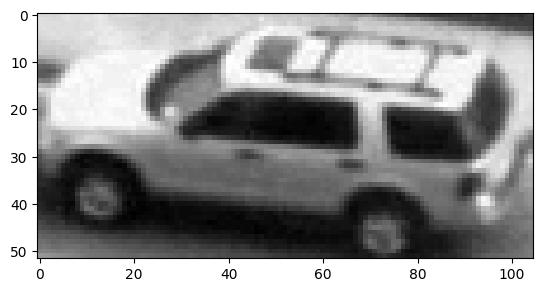

Tracking object through video...


Tracking frames: 100%|██████████| 415/415 [1:48:08<00:00, 15.63s/it]


Tracking video saved to output/car_tracked.mp4


[[52, 108, 105, 52],
 [52, 108, 157, 160],
 [53, 110, 158, 162],
 [51, 110, 156, 162],
 [52, 112, 157, 164],
 [52, 112, 157, 164],
 [53, 114, 158, 166],
 [53, 114, 158, 166],
 [52, 115, 157, 167],
 [53, 117, 158, 169],
 [53, 116, 158, 168],
 [52, 118, 157, 170],
 [51, 119, 156, 171],
 [52, 119, 157, 171],
 [52, 121, 157, 173],
 [52, 121, 157, 173],
 [51, 122, 156, 174],
 [52, 123, 157, 175],
 [50, 123, 155, 175],
 [51, 125, 156, 177],
 [50, 125, 155, 177],
 [50, 127, 155, 179],
 [50, 127, 155, 179],
 [53, 128, 158, 180],
 [54, 130, 159, 182],
 [58, 129, 163, 181],
 [58, 132, 163, 184],
 [61, 132, 166, 184],
 [62, 134, 167, 186],
 [63, 132, 168, 184],
 [65, 135, 170, 187],
 [69, 136, 174, 188],
 [73, 135, 178, 187],
 [76, 138, 181, 190],
 [80, 139, 185, 191],
 [86, 139, 191, 191],
 [88, 142, 193, 194],
 [94, 141, 199, 193],
 [97, 143, 202, 195],
 [101, 144, 206, 196],
 [106, 144, 211, 196],
 [109, 146, 214, 198],
 [114, 146, 219, 198],
 [118, 148, 223, 200],
 [122, 148, 227, 200],
 [126

In [13]:
print("=== Tracking Car ===")
track_object_in_video("data/car2.npy", "output/car_tracked.mp4")

### Track Helicopter Video (Optional)

Uncomment the following cell to track the helicopter video as well.


=== Tracking Helicopter ===
Loading video from data/landing.npy...
Video loaded: 50 frames, 1000x1100
Click and drag to select the object to track. Close the window when done.
Selected bounding box: [442, 80, 118, 53]


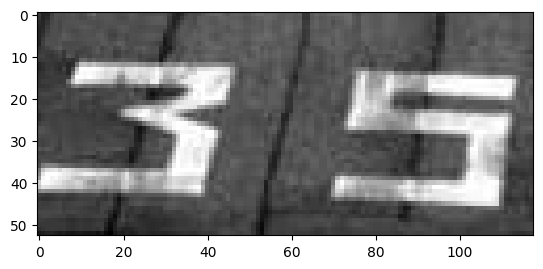

Tracking object through video...


Tracking frames: 100%|██████████| 50/50 [10:44<00:00, 12.89s/it]


Tracking video saved to output/landing_tracked.mp4
Helicopter tracking completed: 51 frames


In [17]:
# Uncomment to track helicopter video
print("\n=== Tracking Helicopter ===")
helicopter_bboxes = track_object_in_video("data/landing.npy", "output/landing_tracked.mp4")
print(f"Helicopter tracking completed: {len(helicopter_bboxes)} frames")